In [1]:
%cd /content/drive/MyDrive/MTS ML Cup

/content/drive/MyDrive/MTS ML Cup


# Импорт библиотек

In [ ]:
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [ ]:
!pip install implicit

In [ ]:
!pip install catboost

In [ ]:
!pip install polars

In [ ]:
import pandas as pd
import numpy as np
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import polars as pl
import pyarrow as pa

In [ ]:
!pip install feather-format >> none

In [ ]:
RAND = 42

# Загрузка и обработка данных

In [ ]:
id_to_submit = pd.read_parquet('submit.pqt')

In [ ]:
id_to_submit.head(3)

,user_id
221301,221301
31271,31271
211594,211594


In [ ]:
id_to_submit.info

<bound method DataFrame.info of         user_id
221301   221301
31271     31271
211594   211594
253119   253119
192578   192578
...         ...
145307   415284
145308   415285
145309   415286
145312   415306
145315   415315

[144724 rows x 1 columns]>

In [ ]:
data = pd.read_feather('dataset_full.feather')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   region_name            category      
 1   city_name              category      
 2   cpe_manufacturer_name  category      
 3   cpe_model_name         category      
 4   url_host               category      
 5   cpe_type_cd            category      
 6   cpe_model_os_type      category      
 7   price                  float32       
 8   date                   datetime64[ns]
 9   part_of_day            category      
 10  request_cnt            int8          
 11  user_id                int32         
dtypes: category(8), datetime64[ns](1), float32(1), int32(1), int8(1)
memory usage: 9.0 GB


In [ ]:
data['region_name'] = data['region_name'].cat.codes
data['city_name'] = data['city_name'].cat.codes
data['cpe_manufacturer_name'] = data['cpe_manufacturer_name'].cat.codes
data['cpe_model_name'] = data['cpe_model_name'].cat.codes
data['cpe_type_cd'] = data['cpe_type_cd'].cat.codes
data['part_of_day'] = data['part_of_day'].cat.codes
data['cpe_model_os_type'] = data['cpe_model_os_type'].cat.codes
data['url_host'] = data['url_host'].cat.codes
data['date'] = pd.to_datetime(data['date'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322899435 entries, 0 to 322899434
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   region_name            int8          
 1   city_name              int16         
 2   cpe_manufacturer_name  int8          
 3   cpe_model_name         int16         
 4   url_host               int32         
 5   cpe_type_cd            int8          
 6   cpe_model_os_type      int8          
 7   price                  float32       
 8   date                   datetime64[ns]
 9   part_of_day            int8          
 10  request_cnt            int8          
 11  user_id                int32         
dtypes: datetime64[ns](1), float32(1), int16(2), int32(2), int8(6)
memory usage: 9.0 GB


In [ ]:
data = pl.from_pandas(data)

In [ ]:
data['cpe_type_cd'].value_counts()

cpe_type_cd,counts
i8,u32
0,27952
3,53768
2,322781599
1,36116


In [ ]:
targets = pd.read_parquet('public_train.pqt')

In [ ]:
targets = pa.Table.from_pandas(targets)

In [ ]:
pd.DataFrame([(z.name, z.type) for z in targets.schema],
             columns=[['field', 'type']])

,field,type
0,age,double
1,is_male,string
2,user_id,int64
3,__index_level_0__,int64


In [ ]:
%%time
user_info = data.groupby(['user_id'], maintain_order=True).agg(
    [pl.sum("request_cnt"),
     pl.last("cpe_type_cd"),
     pl.last("region_name")])
user_info

CPU times: user 9.18 s, sys: 4.17 s, total: 13.4 s
Wall time: 5.93 s


user_id,request_cnt,cpe_type_cd,region_name
i32,i64,i8,i8
45098,2261,2,21
117132,1286,2,60
79395,3306,2,60
91294,2437,2,21
161323,441,2,70
304574,198,2,74
204489,1014,2,63
148545,5033,2,70
16874,2849,2,39


In [ ]:
pod_agg = data.pivot(index='user_id',
                     columns='part_of_day',
                     values='request_cnt',
                     aggregate_fn='sum')
pod_agg.head()

user_id,2,0,1,3
i32,i64,i64,i64,i64
45098,610,770,624,257
117132,238,614,430,4
79395,638,1239,1001,428
91294,511,833,836,257
161323,243,99,91,8


In [ ]:
pod_agg.shape

(415317, 5)

## Embeddings по URL
Создаем эмбеддинги по url

In [ ]:
!pip install faiss-cpu --no-cache

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data_agg = data.groupby(['user_id', 'url_host'],
                        maintain_order=True).agg(pl.sum("request_cnt"))

In [ ]:
url_set = set(data_agg['url_host'].to_pandas())
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
usr_set = set(data_agg['user_id'].to_pandas())
print(f'{len(usr_set)} users')
usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

199683 urls
415317 users


In [ ]:
%%time
values = np.array(data_agg['request_cnt'].to_pandas())
rows = np.array(data_agg['user_id'].to_pandas().map(usr_dict))
cols = np.array(data_agg['url_host'].to_pandas().map(url_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)),
                              shape=(rows.max() + 1, cols.max() + 1))
als = implicit.approximate_als.FaissAlternatingLeastSquares(
    factors=150,
    iterations=50,
    use_gpu=False,
    calculate_training_loss=True,
    regularization=0.1)

CPU times: user 2.71 s, sys: 967 ms, total: 3.68 s
Wall time: 3.78 s


In [ ]:
%%time
als.fit(mat)

In [ ]:
u_factors = als.model.user_factors
d_factors = als.model.item_factors

In [ ]:
%%time
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(u_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)

In [ ]:
usr_emb.to_csv('embeddings/url_emb.csv', index=False)

## Embeddings по region_name
Создаем эмбеддинги по региону

In [ ]:
data_agg_reg = data.groupby(['user_id', 'region_name'], maintain_order=True) \
    .agg(pl.sum("request_cnt"))

In [ ]:
region_set = set(data_agg_reg['region_name'].to_pandas())
print(f'{len(region_set)} regions')
region_dict = {
    reg: reg_id
    for reg, reg_id in zip(region_set, range(len(region_set)))
}

81 regions


In [ ]:
%%time
values = np.array(data_agg_reg['request_cnt'].to_pandas())
rows = np.array(data_agg_reg['user_id'].to_pandas().map(usr_dict))
cols = np.array(data_agg_reg['region_name'].to_pandas().map(region_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)),
                              shape=(rows.max() + 1, cols.max() + 1))
als = implicit.approximate_als.FaissAlternatingLeastSquares(
    factors=30,
    iterations=20,
    use_gpu=False,
    calculate_training_loss=True,
    regularization=0.1)

CPU times: user 486 ms, sys: 1.04 ms, total: 487 ms
Wall time: 482 ms


In [ ]:
%%time
als.fit(mat)

In [ ]:
u_factors = als.model.user_factors
d_factors = als.model.item_factors

In [ ]:
%%time
inv_usr_map = {v: k for k, v in usr_dict.items()}
reg_emb = pd.DataFrame(u_factors)
reg_emb['user_id'] = reg_emb.index.map(inv_usr_map)

CPU times: user 558 ms, sys: 11.1 ms, total: 569 ms
Wall time: 566 ms


In [ ]:
reg_emb.to_csv('embeddings/reg_emb.csv', index=False)

## Embeddings по city_name
Создаем эмбеддинги по городу

In [ ]:
data_agg_city = data.groupby(['user_id', 'city_name'], maintain_order=True) \
    .agg(pl.sum("request_cnt"))

In [ ]:
city_set = set(data_agg_city['city_name'].to_pandas())
print(f'{len(city_set)} cities')
city_dict = {
    city: city_id
    for city, city_id in zip(city_set, range(len(city_set)))
}

985 cities


In [ ]:
%%time
values = np.array(data_agg_city['request_cnt'].to_pandas())
rows = np.array(data_agg_city['user_id'].to_pandas().map(usr_dict))
cols = np.array(data_agg_city['city_name'].to_pandas().map(city_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)),
                              shape=(rows.max() + 1, cols.max() + 1))
als = implicit.approximate_als.FaissAlternatingLeastSquares(
    factors=50,
    iterations=30,
    use_gpu=False,
    calculate_training_loss=True,
    regularization=0.1)

CPU times: user 478 ms, sys: 4 ms, total: 482 ms
Wall time: 484 ms


In [ ]:
%%time
als.fit(mat)

In [ ]:
u_factors = als.model.user_factors
d_factors = als.model.item_factors

In [ ]:
%%time
inv_usr_map = {v: k for k, v in usr_dict.items()}
city_emb = pd.DataFrame(u_factors)
city_emb['user_id'] = city_emb.index.map(inv_usr_map)

CPU times: user 486 ms, sys: 11 ms, total: 497 ms
Wall time: 494 ms


In [ ]:
city_emb.to_csv('embeddings/city_emb.csv', index=False)

## Embeddings по cpe_model_name
Создаем эмбеддинги по модели телефона

In [ ]:
data_agg_model = data.groupby(['user_id', 'cpe_model_name'], maintain_order=True) \
    .agg(pl.sum("request_cnt"))

In [ ]:
model_set = set(data_agg_model['cpe_model_name'].to_pandas())
print(f'{len(model_set)} cities')
model_dict = {
    model: model_id
    for model, model_id in zip(model_set, range(len(model_set)))
}

599 cities


In [ ]:
%%time
values = np.array(data_agg_model['request_cnt'].to_pandas())
rows = np.array(data_agg_model['user_id'].to_pandas().map(usr_dict))
cols = np.array(data_agg_model['cpe_model_name'].to_pandas().map(model_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)),
                              shape=(rows.max() + 1, cols.max() + 1))
als = implicit.approximate_als.FaissAlternatingLeastSquares(
    factors=50,
    iterations=30,
    use_gpu=False,
    calculate_training_loss=True,
    regularization=0.1)

CPU times: user 400 ms, sys: 5.95 ms, total: 406 ms
Wall time: 400 ms


In [ ]:
%%time
als.fit(mat)

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 2min 54s, sys: 45.3 s, total: 3min 40s
Wall time: 1min 8s


In [ ]:
u_factors = als.model.user_factors
d_factors = als.model.item_factors

In [ ]:
%%time
inv_usr_map = {v: k for k, v in usr_dict.items()}
model_emb = pd.DataFrame(u_factors)
model_emb['user_id'] = model_emb.index.map(inv_usr_map)

CPU times: user 521 ms, sys: 11.1 ms, total: 532 ms
Wall time: 512 ms


In [ ]:
model_emb.to_csv('embeddings/model_emb.csv', index=False)

# Оценка по полу

In [ ]:
%%time
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(u_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb, how='inner', on=['user_id'])
df = df[df['is_male'] != 'NA']
df = df.dropna()
df['is_male'] = df['is_male'].map(int)
df['is_male'].value_counts()

CPU times: user 2.37 s, sys: 294 ms, total: 2.66 s
Wall time: 2.62 s


1    135331
0    128994
Name: is_male, dtype: int64

In [ ]:
%%time
x_train, x_test, y_train, y_test = train_test_split(df.drop(
    ['user_id', 'age', 'is_male'], axis=1),
    df['is_male'],
    test_size=0.33,
    random_state=RAND)
clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose=False)
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.665
CPU times: user 4min 58s, sys: 6.1 s, total: 5min 4s
Wall time: 1min 31s


In [ ]:
id_to_submit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144724 entries, 221301 to 145315
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  144724 non-null  int64
dtypes: int64(1)
memory usage: 2.2 MB


In [ ]:
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis=1),
        df['is_male'],
        verbose=False)
id_to_submit['is_male'] = clf.predict_proba(
    id_to_submit.merge(usr_emb, how='inner', on=['user_id']))[:, 1]

# Оценка по возрасту

In [ ]:
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
def age_bucket(x):
    return bisect.bisect_left([18, 25, 35, 45, 55, 65], x)

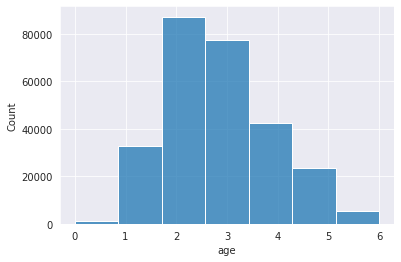

In [ ]:
df = usr_targets.merge(usr_emb, how='inner', on=['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins=7)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(
    ['user_id', 'age', 'is_male'], axis=1),
    df['age'],
    test_size=0.33,
    random_state=RAND)

clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose=False)
print(
    m.classification_report(y_test,
                            clf.predict(x_test),
                            target_names=[
                                '<18', '18-25', '25-34', '35-44', '45-54',
                                '55-65', '65+'
                            ]))

              precision    recall  f1-score   support

         <18       0.00      0.00      0.00       349
       18-25       0.51      0.30      0.38     10663
       25-34       0.48      0.63      0.54     28815
       35-44       0.39      0.52      0.45     25791
       45-54       0.37      0.20      0.26     13931
       55-65       0.40      0.18      0.25      7688
         65+       0.34      0.01      0.02      1849

    accuracy                           0.44     89086
   macro avg       0.36      0.26      0.27     89086
weighted avg       0.43      0.44      0.41     89086



In [ ]:
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis=1),
        df['age'],
        verbose=False)

In [ ]:
id_to_submit['age'] = clf.predict(id_to_submit[['user_id'
                                                ]].merge(usr_emb,
                                                         how='left',
                                                         on=['user_id']))

# Submission

In [ ]:
import datetime

cur_time = str(datetime.datetime.now()).replace(' ', '_')[:16]
sub_name = 'submissions/submission_' + cur_time + '.csv'
id_to_submit.to_csv(sub_name, index = False)